In [59]:
import numpy as np
import pandas as pd
import os
from scipy import optimize
from scipy.signal import butter, lfilter, freqz

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]

In [2]:
def align_yaxis(ax1, v1, ax2, v2):
    """adjust ax2 ylimit so that v2 in ax2 is aligned to v1 in ax1"""
    _, y1 = ax1.transData.transform((0, v1))
    _, y2 = ax2.transData.transform((0, v2))
    adjust_yaxis(ax2,(y1-y2)/2,v2)
    adjust_yaxis(ax1,(y2-y1)/2,v1)

def adjust_yaxis(ax,ydif,v):
    """shift axis ax by ydiff, maintaining point v at the same location"""
    inv = ax.transData.inverted()
    _, dy = inv.transform((0, 0)) - inv.transform((0, ydif))
    miny, maxy = ax.get_ylim()
    miny, maxy = miny - v, maxy - v
    if -miny>maxy or (-miny==maxy and dy > 0):
        nminy = miny
        nmaxy = miny*(maxy+dy)/(miny+dy)
    else:
        nmaxy = maxy
        nminy = maxy*(miny+dy)/(maxy+dy)
    ax.set_ylim(nminy+v, nmaxy+v)
    
def fit(x, x0, x1, b, k1, k2, k3):
    condlist = [x < x0, (x >= x0) & (x < x1), x >= x1]
    funclist = [lambda x: k1*x + b, lambda x: k1*x0 + b + k2*(x-x0), lambda x: k1*x0 + b + k2*(x1-x0) + k3*(x - x1)]
    return np.piecewise(x, condlist, funclist)

def invfit(x, x0, x1, b, k1, k2, k3):
    condlist = [x < k1*x0+b, (x >= k1*x0+b) & (x < k1*x0 + b + k2*(x1-x0)), x >= k1*x0 + b + k2*(x1-x0)]
    funclist = [lambda x: (x - b) / k1, lambda x: (x - k1*x0 - b) / k2 + x0, lambda x: (x - k1*x0 - b - k2*(x1-x0)) / k3 + x1]
    return np.piecewise(x, condlist, funclist)

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [43]:
esc_file=os.path.expanduser('~/Documents/log/2019-04-05T17-08-41/logstream_ActAdapEsc.bin')
wrench_file=os.path.expanduser('~/Documents/log/2019-04-05T17-08-41/logstream_ATINetboxWrench.bin')

In [44]:
esc_fmt = np.dtype([('idx', '>u1'),
                    ('cmdSec', '>u4'), ('cmdUsec', '>u4'), ('cmd', '>i4'), ('cmdVel', '>f8'),
                    ('fbSec', '>u4'), ('fbUsec', '>u4'), ('angVel', '>f8'),

                    ('length', '>u2'),
                    ('counts', '>u2'),
                    ('voltage', '>u2'),
                    ('temperature', '>u2'),
                    ('current', '>u2'),
                    ('id', 'u1')])

wrench_fmt = np.dtype([('seq', '>u4'),
                       ('timeBase', '>u2'), ('timeContext', '>u1'), ('timeSec', '>u4'), ('timeUsec', '>u4'),
                       ('frame_id', '>u4'),

                       ('fx', '>f8'), ('fy', '>f8'), ('fz', '>f8'),

                       ('tx', '>f8'), ('ty', '>f8'), ('tz', '>f8')])

In [45]:
esc_dat = np.fromfile(esc_file, dtype=esc_fmt)
esc = pd.DataFrame(esc_dat.byteswap().newbyteorder())

mot0=esc.loc[(esc['idx'] == 0)]
mot0_cmdTime = mot0.cmdSec + mot0.cmdUsec / (1000.0 * 1000.0)
mot0_fbTime = mot0.fbSec + mot0.fbUsec / (1000.0 * 1000.0)

mot0_nonzero = mot0[mot0.angVel != 0]
mot0_nonzero_fbTime = mot0_fbTime[mot0.angVel != 0]

wrench_dat = np.fromfile(wrench_file, dtype=wrench_fmt)
wrench = pd.DataFrame(wrench_dat.byteswap().newbyteorder())
wrench_time = wrench.timeSec + wrench.timeUsec / (1000.0 * 1000.0)

In [52]:
timeDiff = mot0_fbTime[mot0_fbTime.size-1] - mot0_fbTime[0]
timeDiff

9.08201100000042

In [53]:
wrench_end = wrench[wrench_time - wrench_time[0] > timeDiff].index[0]
wrench_end

63020

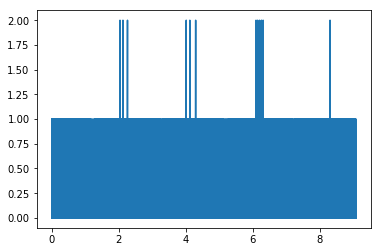

In [54]:
plt.plot(mot0_fbTime - mot0_fbTime[0], mot0.counts)

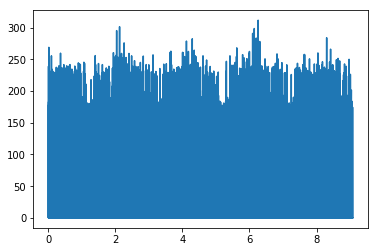

In [55]:
plt.plot(mot0_fbTime - mot0_fbTime[0], mot0.angVel)

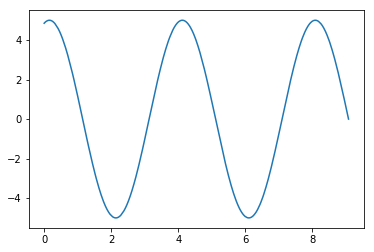

In [56]:
plt.plot(mot0_cmdTime - mot0_cmdTime[0], mot0.cmdVel)

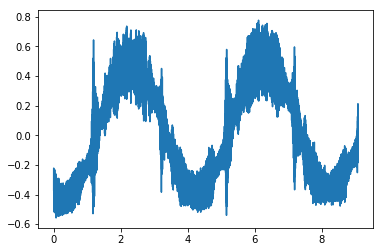

In [58]:
plt.plot(wrench_time[:wrench_end]-wrench_time[0], wrench.fz[:wrench_end])

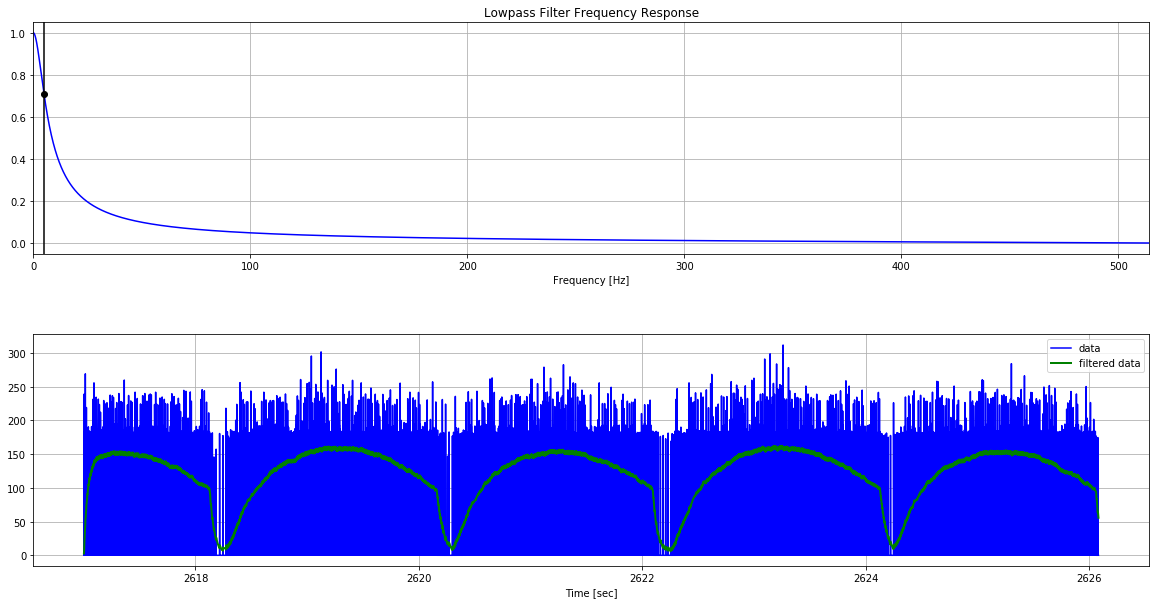

In [69]:
# Filter requirements.
order = 1
fs = 1/np.mean(np.diff(mot0_fbTime))       # sample rate, Hz
cutoff = 5  # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, fs, order)

# Plot the frequency response.
w, h = freqz(b, a, worN=8000)
plt.subplot(2, 1, 1)
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()

# Filter the data, and plot both the original and filtered signals.
y = butter_lowpass_filter(mot0.angVel, cutoff, fs, order)

plt.subplot(2, 1, 2)
plt.plot(mot0_fbTime, mot0.angVel, 'b-', label='data')
plt.plot(mot0_fbTime, y, 'g-', linewidth=2, label='filtered data')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()

plt.subplots_adjust(hspace=0.35)
plt.show()

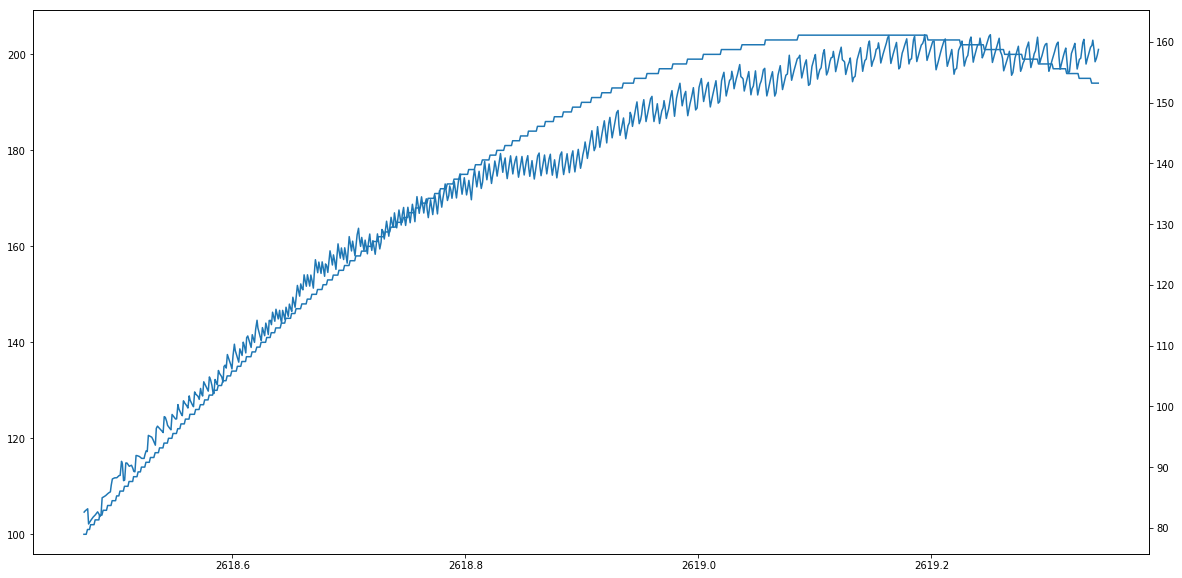

In [98]:
fig, ax1 = plt.subplots()

ax1.plot(mot0_cmdTime[1500:2400], np.abs(mot0.cmd[1500:2400]))

ax2 = ax1.twinx()
ax2.plot(mot0_fbTime[1500:2400], y[1500:2400])

align_yaxis(ax1, 0, ax2, 0)

0.7089580940582408 12.503583414296301


/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


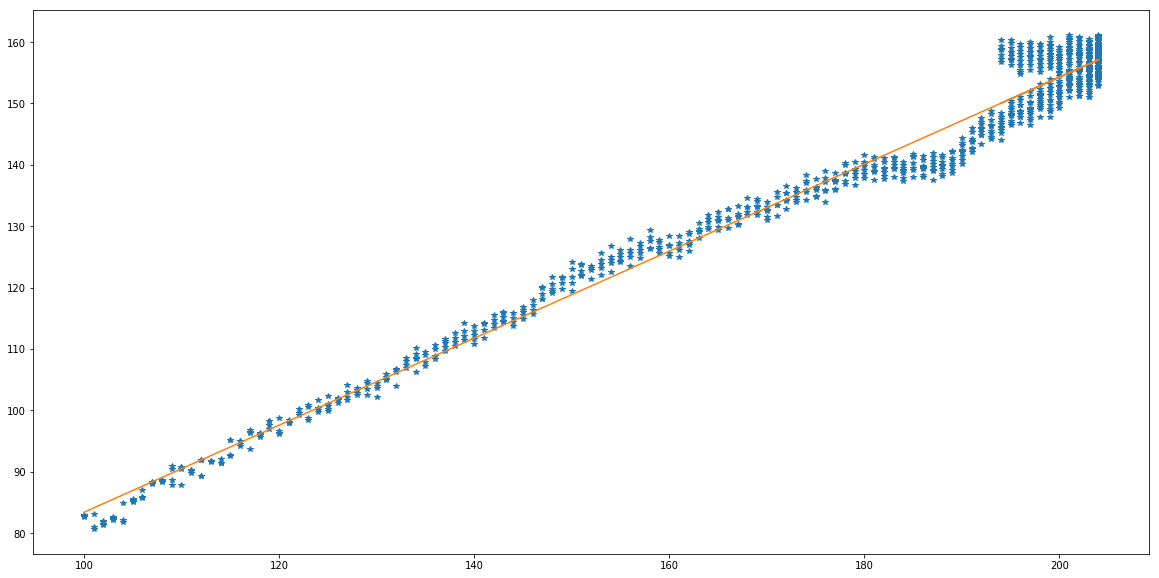

In [104]:
#cmdLow = np.abs(mot0.cmd[(np.abs(mot0.cmd) > 125) & (np.abs(mot0.cmd) < 300) & (mot0.angVel > 100)].values.astype("float64"))
#angVelLow = mot0.angVel[(np.abs(mot0.cmd) > 125)  & (np.abs(mot0.cmd) < 300) & (mot0.angVel > 100)].values

cmdLow = np.abs(mot0.cmd[1500:2400].values.astype("float64"))
A = np.vstack([cmdLow, np.ones(len(cmdLow))]).T
mLow, cLow = np.linalg.lstsq(A, y[1500:2400])[0]
print(mLow, cLow)
plt.plot(cmdLow, y[1500:2400], '*')
plt.plot(cmdLow, mLow*cmdLow + cLow)

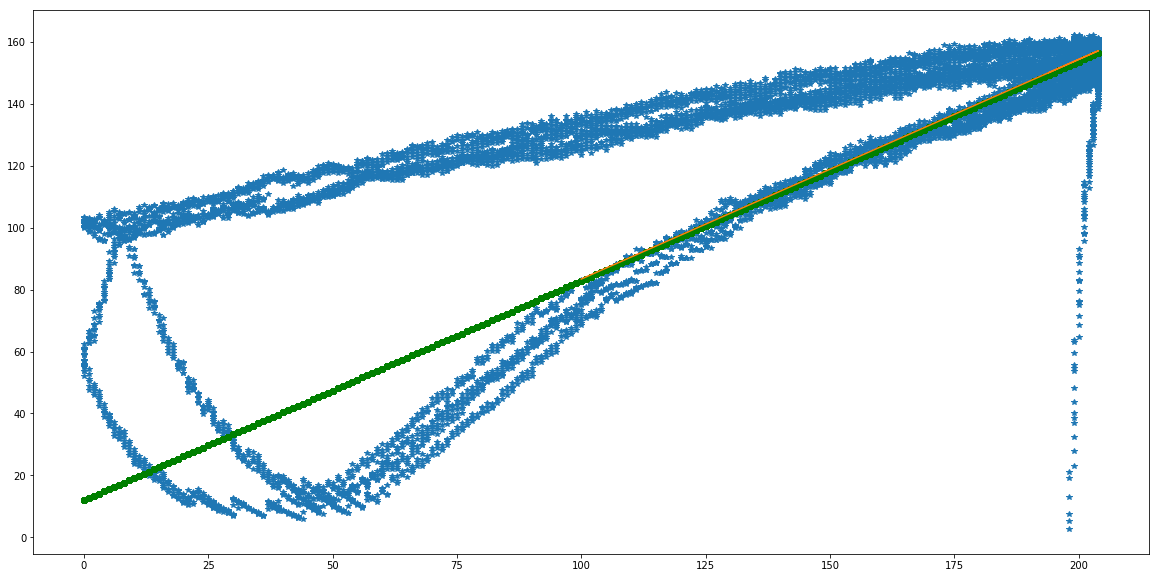

In [110]:
cmd = np.abs(mot0.cmd.values.astype("float64"))
plt.plot(cmd, y, '*')
plt.plot(cmd, fit(cmd, 1000, 1001, 12, 0.708, 0, 0), 'go', linestyle='None')
plt.plot(cmdLow, mLow*cmdLow + cLow)